# Image classification

**DESCRIPTION**

Facial recognition is a biometric alternative that measures unique characteristics of a human face. Applications available today include flight check in, tagging friends and family members in photos, and “tailored” advertising. You are a computer vision engineer who needs to develop a
face recognition programme with deep convolutional neural networks.

**Objective:** Use a deep convolutional neural network to perform facial recognition using Keras.

**Dataset Details:**

ORL face database composed of 400 images of size 112 x 92. There are 20 people, 20 images per person. The images were taken at different times, lighting and facial expressions. The faces are in an upright position in frontal view, with a slight left-right rotation.

**Link to the Dataset:** https://github.com/gpurci/ORL_faces

**Prerequisites:**
Keras
Scikit Learn
Steps to be followed:
1. Input the required libraries
2. Load the dataset after loading the dataset, you have to normalize every image.
3. Split the dataset
4. Transform the images to equal sizes to feed in CNN
5. Build a CNN model that has 3 main layers:

i. Convolutional Layer
ii. Pooling Layer
iii. Fully Connected Layer

6. Train the model
7. Plot the result
8. Iterate the model until the accuracy is above 90%

## Setup


###Instal library

In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 9.7 MB/s 


In [2]:
#import data
!git clone https://github.com/gpurci/ORL_faces

Cloning into 'ORL_faces'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [75]:
#clone augmentation class
!git clone https://github.com/gpurci/ImageAugmentation

Cloning into 'ImageAugmentation'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 49 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [74]:
'''
try:
    shutil.rmtree('/content/ImageAugmentation')
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
 '''

' '

In [84]:
#import augmentation class
from ImageAugmentation.image_augmentation import AugmentImage

###Import necessary libraries:

In [6]:
import math
import numpy as np
import pandas as pd
import os
import shutil
import pathlib
import PIL
import cv2
import progressbar

from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

###Functions

In [8]:
#perform confusion matrix to dataframe
def pd_df_multi_class_confusion_matrix(pd_s_target, pd_s_predict):
  class_sample_ = pd_s_target.unique()
  cm = confusion_matrix(pd_s_target, pd_s_predict, labels=class_sample_)
  multi_columns = zip(['Predicted label']*(len(class_sample_)), class_sample_)
  multi_index = zip(['Actual label']*(len(class_sample_)), class_sample_)
  multi_columns = pd.MultiIndex.from_tuples(list(multi_columns))
  multi_index = pd.MultiIndex.from_tuples(list(multi_index))
  return pd.DataFrame(cm, columns=multi_columns, index=multi_index)

## Download and explore the dataset

###Data aquisition

In [9]:
#read numpy format
#read train feature data
np_train_X = np.load('ORL_faces/trainX.npy')
#read train target data
np_train_y = np.load('ORL_faces/trainY.npy')
#read test feature data
np_test_X = np.load('ORL_faces/testX.npy')
#read test target data
np_test_y = np.load('ORL_faces/testY.npy')

In [10]:
np_train_X.shape

(240, 10304)

In [11]:
#show all classes from train data
np.unique(np_train_y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint8),
 array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12]))

In [12]:
#show all classes from test data
np.unique(np_test_y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

###Create path for data

In [13]:
def createDirectory(path):
  # checking if the directory demo_folder 
  # exist or not
  if not os.path.exists(path):
    # if the demo_folder directory is not present 
    # then create it
    os.makedirs(path)

In [14]:
#create directory of all class name of train data
path = 'data/train'
for i in np.unique(np_train_y):
  tmp_path = '{}/{}'.format(path, i)
  createDirectory(tmp_path)

In [15]:
#create directory of all class name of test data
path = 'data/test'
for i in np.unique(np_test_y):
  tmp_path = '{}/{}'.format(path, i)
  createDirectory(tmp_path)

###Data augmentation

####Augmantation function

In [85]:
aug_img  = AugmentImage()

In [89]:
aug_img.lst_log

['noise',
 'rotationAndNoise',
 'rotationAndNoise',
 'noise',
 'rotationAndNoise',
 'noise',
 'noise',
 'noise',
 'rotationAndNoise',
 'noise',
 'Wiener',
 '\t size_kernel:3',
 '\t isDisc:False',
 '\t tmp_kernel:[[ 0.          0.05822281  0.        ]\n [-0.03618015  0.04634376  0.06472376]\n [ 0.          0.0580042   0.        ]]',
 '\t Lambda:0.28411469686386964']

In [87]:
def data_augmentation(path, np_array_X, np_array_y, nbr_gen_for_sample):
  widgets = [' [',
         progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]
  max_value_bar = np_array_X.shape[0]*(nbr_gen_for_sample + 1)
  bar = progressbar.ProgressBar(
                      max_value=max_value_bar, 
                      widgets=widgets).start()
  shape_ = np_array_X[0].shape
  #index filename for image name
  idx_filename = 0
  #save row data
  for np_feature, np_target in zip(np_array_X, np_array_y):
    filename = '{}/{}/{}.png'.format(path, np_target, idx_filename)
    lst_filename.append(filename)
    cv2.imwrite(filename, np_feature.astype(np.uint8))
    #updata name of next filename
    idx_filename+=1
    bar.update(idx_filename)

  #save generated data
  for i in range(nbr_gen_for_sample):
    for np_feature, np_target in zip(np_array_X, np_array_y):
      #get random index to generate image
      idx_img_gen = np.random.randint(low=0, high=3, size=1)[0]
      lst_idx_gen.append(idx_img_gen)
      print('shape', np_feature.shape)
      np_feature = np_feature.reshape(shape_[0], shape_[1], 1)
      tmp_np_gen_arr = aug_img.getAugmentFunc(idx_img_gen)(np_feature)
      tmp_np_gen_arr = aug_img.flipArray(tmp_np_gen_arr).reshape(shape_)
      #save image
      filename = '{}/{}/{}.png'.format(path, np_target, idx_filename)
      lst_filename.append(filename)
      cv2.imwrite(filename, tmp_np_gen_arr.astype(np.uint8))
      #updata name of next filename
      idx_filename+=1
      bar.update(idx_filename)



####Perform augmentation

In [57]:
test_ = np.arange(100).reshape((10, 10, 1))

In [50]:
test_[:,:,0].shape

(10, 10)

In [59]:
np.zeros((test_.shape)).shape

(10, 10, 1)

In [88]:
#generate train data
lst_idx_gen = []             #list of index of augmentation function, see lst_augmentation_func
                             #0 = noise, 1 = rotationAndNoise, 2 = Wiener
lst_wiener = []              #list of dictionary with random parameter function
                             #dictionary keys: size_kernel, isDisc, tmp_kernel, Lambda
lst_filename = []            #list of name of all generated image
nbr_gen_for_sample = 100     #number of generated image for one image
path = 'data/train'          #file where is saved all image
np_train_X = np_train_X.reshape(np_train_X.shape[0], 112, 92, 1)
#generate train data
data_augmentation(path, np_train_X, np_train_y, nbr_gen_for_sample)

 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 

shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)
shape (112, 92, 1)


ValueError: ignored

In [ ]:
#generate test data
lst_idx_gen = []             #list of index of augmentation function, see lst_augmentation_func
                             #0 = noise, 1 = rotationAndNoise, 2 = Wiener
lst_wiener = []              #list of dictionary with random parameter function
                             #dictionary keys: size_kernel, isDisc, tmp_kernel, Lambda
lst_filename = []            #list of name of all generated image
nbr_gen_for_sample = 40      #number of generated image for one image
path = 'data/test'          #file where is saved all image
np_test_X = np_test_X.reshape(np_test_X.shape[0], 112, 92, 1)
#generate test data
data_augmentation(path, np_test_X, np_test_y, nbr_gen_for_sample)

 [elapsed time: 0:00:09] |********************************* | (ETA:   0:00:00) 

###Upload train and test data

In [ ]:
import pathlib

In [ ]:
train_dir = 'data/train'
train_dir = pathlib.Path(train_dir)

In [ ]:
test_dir = 'data/test'
test_dir = pathlib.Path(test_dir)

In [ ]:
image_count = len(list(train_dir.glob('*/*.png')))
print('Number of train image {}'.format(image_count))

Number of train image 24240


In [ ]:
image_count = len(list(test_dir.glob('*/*.png')))
print('Number of test image {}'.format(image_count))

Number of test image 6560


## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take us from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 10
img_height = 112
img_width = 92
img_channel = 1

Split data in test and validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=12534,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='grayscale')

Found 24240 files belonging to 20 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=42,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='grayscale')

Found 6560 files belonging to 20 classes.


We can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names) #show all class name

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


## Visualize the data

Here are the first nine images from the training dataset:

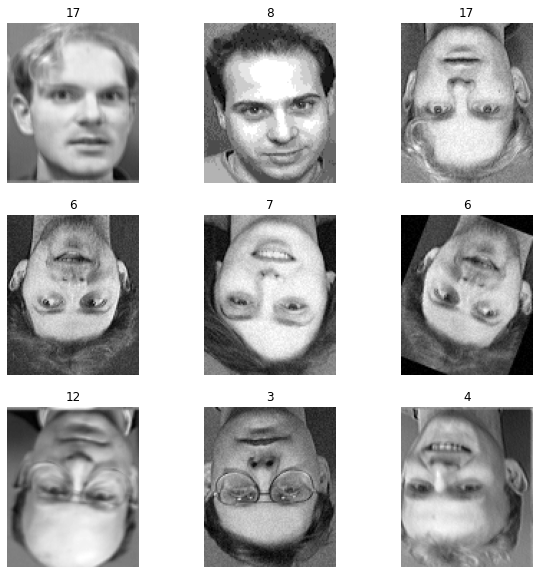

In [ ]:
#show 9 person, after image augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)                #create 3x3 subplot
    #convert image to numpy array, type - uint8, 
    img = images[i].numpy().astype("uint8").reshape(img_height, img_width)
    plt.imshow(img, cmap='gray')                 #plot grayscale image
    plt.title(class_names[np.argmax(labels[i])]) #put name of person
    plt.axis("off")
plt.show()

## Configure the dataset for performance

Make sure to use buffered prefetching, so we can yield data from disk without having I/O become blocking. These are two important methods we need to use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model. If our dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## A basic Keras model


### Create the model

In [ ]:
num_classes = len(class_names)

input = Input(
              shape=(img_height, img_width, img_channel),
              name='Input',
              dtype=np.uint8
              )
#We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
x = layers.Rescaling(1./255, 
                     input_shape=(img_height, img_width, img_channel))(input)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(num_classes * 2, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(num_classes, activation='softmax')(x)


In [ ]:
#create model
model = Model(input, output)

### Compile the model

We will, use the `adam` optimizer and `categorical_crossentropy` loss function.

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 112, 92, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 112, 92, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 112, 92, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 46, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 46, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 56, 46, 128)      512       
 ormalization)                                               

### Train and visualize the model results

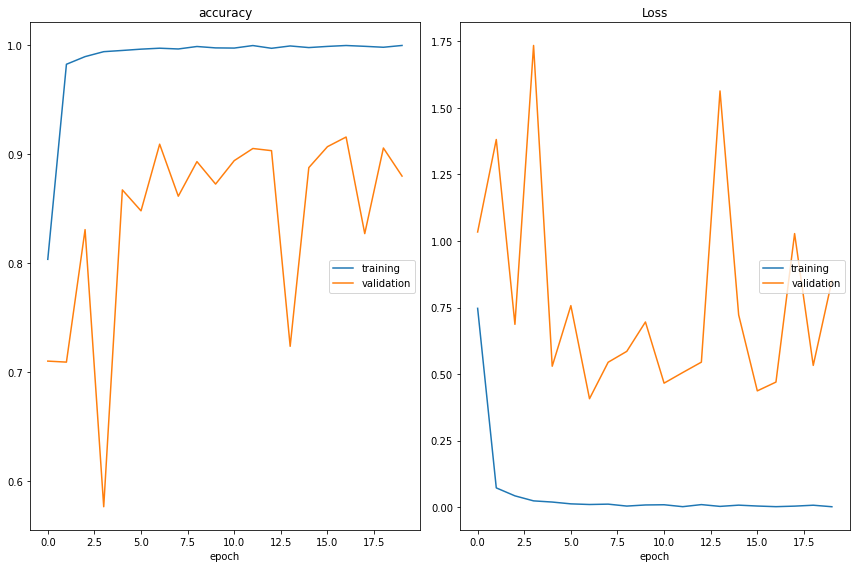

accuracy
	training         	 (min:    0.804, max:    1.000, cur:    1.000)
	validation       	 (min:    0.577, max:    0.916, cur:    0.880)
Loss
	training         	 (min:    0.001, max:    0.747, cur:    0.001)
	validation       	 (min:    0.407, max:    1.735, cur:    0.851)
2424/2424 [==============================] - 44s 18ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.8506 - val_accuracy: 0.8799


In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[PlotLossesKerasTF()]
)

## Predict on test data

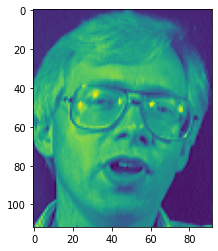

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to person 1 with a 99.99 percent confidence.


In [ ]:
#/data - folder with train and test data
#/test - folder with test data
#/1 - follder with all augmentted data of person @1@
#/10.png - image name of one test data of person @1@
test_path = '/data/test/1/10.png'

img = tf.keras.utils.load_img(
    test_path, 
    target_size=(img_height, img_width, img_channel),  #size of image, we have 1 chanel, grayscale image
    color_mode='grayscale'                             #we predict grayscale image
)
img_array = tf.keras.utils.img_to_array(img)           #convert image to array
img_array = tf.expand_dims(img_array, 0)               #create a batch

plt.imshow(np.array(img_array[0]).reshape(img_height, img_width))
plt.show()                                             #plot image
score = model.predict(img_array)                       #predict class image
print(
    "This image most likely belongs to person {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
#Select random one image from all classes

#/data - folder with train and test data
#/test - folder with test data
root = '/data/test'
lst_rand_one_smpl_class_filename = []                                   #list with random filename
for path, subdirs, files in os.walk(root):
  if (files != [] and files != None):
    idx_img = np.random.randint(low=0, high=len(files), size=1)[0]      #calculate random number from 0 to number of files
    name = files[idx_img]                                               #select random one image
    lst_rand_one_smpl_class_filename.append(os.path.join(path, name))   #save one image from class

lst_rand_one_smpl_class_filename.sort()                                 #sort classes

In [ ]:
#find index of class for a name of person
lst_root_name = lst_rand_one_smpl_class_filename[0].split('/')
[('index: {}'.format(i), name) for i, name in zip(range(len(lst_root_name)), lst_root_name)]

[('index: 0', ''),
 ('index: 1', 'data'),
 ('index: 2', 'test'),
 ('index: 3', '0'),
 ('index: 4', '1762.png')]

1/1 [==============================] - 0s 17ms/step


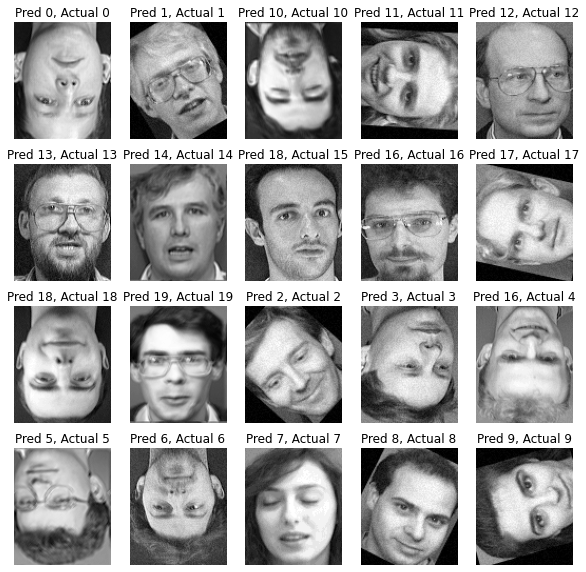

In [ ]:
plt.figure(figsize=(10, 10))
#range 20, we have 20 classes, len(lst_rand_one_smpl_class_filename) = 20
for i, filename in zip(range(20), lst_rand_one_smpl_class_filename):
  ax = plt.subplot(4, 5, i + 1)
  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)             #read grayscale image
  plt.imshow(img, cmap='gray')                                 #plot grayscale image
  img = img.reshape(img_height, img_width, img_channel)
  score = model.predict(np.array([img]))                       #predict name of person
  act_class_name = filename.split('/')[3]                      #get actual class name, @3@ is index of class from filename
  tmp_title = 'Pred {}, Actual {}'.format(class_names[np.argmax(score)], act_class_name)
  plt.title(tmp_title)                                         #set name of image
  plt.axis("off")
plt.show()

In [ ]:
#Get filename for all classes

#/data - folder with train and test data
#/test - folder with test data
root = '/data/test'
d_clas_filename = {}                        #create a dictionary: key - class name, 
                                            #                   : data - tuple of path and filenames
for path, subdirs, files in os.walk(root):
  if (files != [] and files != None):
    key_class_name = path.split('/')[3]     #get class name, @3@ is index of class from path
    d_clas_filename[int(key_class_name)] = (path, files)       #save filename of all classe from test data

In [ ]:
#check finale test evaluation metrics

lst_prediction = []                         #list prediction class
lst_actual = []                             #list actual class
keys = list(d_clas_filename.keys())         #list of all classes
for key in keys:
  path = d_clas_filename[key][0]            #get path of single class
  for filename in d_clas_filename[key][1]:  #loop all filename from a single class
    img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE) #read grayscale image
    img = img.reshape(img_height, img_width, img_channel)                #reshape image
    label = model.predict(np.array([img]))                               #predict name of person
    lst_actual.append(key)                                               #save actual class name
    lst_prediction.append(int(class_names[np.argmax(label)]))            #save predicted class name
  

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 21ms/step


In [ ]:
#Evaluation Metrics test data
print(metrics.classification_report(lst_actual, lst_prediction))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       328
           1       0.97      0.98      0.98       328
           2       0.90      0.94      0.92       328
           3       0.96      0.90      0.93       328
           4       0.91      0.75      0.82       328
           5       0.89      0.99      0.94       328
           6       0.96      0.98      0.97       328
           7       0.62      1.00      0.76       328
           8       0.82      1.00      0.90       328
           9       0.86      0.59      0.70       328
          10       0.97      0.97      0.97       328
          11       0.96      0.98      0.97       328
          12       0.83      0.97      0.89       328
          13       1.00      0.94      0.97       328
          14       0.93      0.95      0.94       328
          15       0.99      0.44      0.61       328
          16       0.90      0.92      0.91       328
          17       0.85    

In [ ]:
#show confusion matrix
pd_df_multi_class_confusion_matrix(pd.Series(lst_actual), pd.Series(lst_prediction))

Predicted label                                               \
                             1    16   11   18   6    7    5    0    14   2    
Actual label 1              323    0    1    0    0    0    0    2    0    0   
             16               0  302    0    0    0    4    0    1    2    1   
             11               0    0  323    1    0    0    0    0    0    1   
             18               0    0    0  239    0   85    0    0    2    0   
             6                0    0    0    0  323    0    0    0    0    0   
             7                0    0    1    0    0  327    0    0    0    0   
             5                0    0    0    0    0    0  324    0    0    0   
             0                4    4    0   19    0    3    0  297    0    0   
             14               1    0    0    0    0    0    5    0  311    0   
             2                0    4    2    0    0    8    0    1    0  308   
             19               0    0    7    0    4    1   33    0    2   26   
             9                0   14    1    0    1   76    0    0   12    1   
             13               0    5    0    0    0    7    0    0    0    4   
             8                0    0    0    0    0    0    0    0    0    0   
             17               0    0    0    0    0    0    0    0    0    0   
             12               0    0    0    1    0    1    0    2    0    0   
             4                3    1    0    0    0    9    1    4    4    0   
             10               0    0    0    0    8    3    0    0    0    0   
             3                1    4    0    0    0    0    0    0    0    1   
             15               1    2    0   54    0    3    0   53    0    0   

                                                                   
                  19   9    13   8    17   12   4    10   3    15  
Actual label 1     0    0    0    0    0    2    0    0    0    0  
             16    0    0    0   14    0    0    3    0    1    0  
             11    0    1    0    2    0    0    0    0    0    0  
             18    0    0    0    0    1    0    0    1    0    0  
             6     5    0    0    0    0    0    0    0    0    0  
             7     0    0    0    0    0    0    0    0    0    0  
             5     0    0    0    0    0    0    4    0    0    0  
             0     0    0    0    0    0    0    0    0    1    0  
             14    2    0    0    0    0    0    9    0    0    0  
             2     1    0    0    3    0    0    0    0    1    0  
             19  221   30    0    3    0    0    0    0    0    1  
             9     0  194    0   22    0    1    0    2    4    0  
             13    2    0  309    0    0    0    0    0    1    0  
             8     0    0    0  327    0    0    0    0    1    0  
             17    0    0    0    0  325    1    2    0    0    0  
             12    0    0    0    0    0  317    7    0    0    0  
             4     0    0    0    2   56    1  247    0    0    0  
             10    0    0    0    0    0    0    0  317    0    0  
             3     0    0    0   27    0    0    0    0  295    0  
             15    0    0    0    0    1   60    0    8    3  143

1055930/1055930 [==============================] - 1s 1us/step


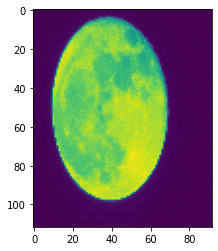

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to person 7 with a 100.00 percent confidence.


In [ ]:
moon_url = "https://tammyscowdogs.files.wordpress.com/2013/11/full-moon-mon-nov-19-2013-012.jpg"
test_path = tf.keras.utils.get_file('1', origin=moon_url) #get image from url link

img = tf.keras.utils.load_img(                         #load image
    test_path,                                         #path of image
    target_size=(img_height, img_width, img_channel),  #size of image, we have 1 chanel, grayscale image
    color_mode='grayscale'                             #we predict grayscale image
)
img_array = tf.keras.utils.img_to_array(img)           #convert image to array
img_array = tf.expand_dims(img_array, 0)               #create a batch

plt.imshow(np.array(img_array[0]).reshape(img_height, img_width))
plt.show()                                             #plot image of moon
score = model.predict(img_array)                       #predict model
print(
    "This image most likely belongs to person {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#Conclusion

Our model predict aproximative 90% of test data, but can detect only trained face, if we have other image can be predicted 100% like a person!